In [1]:
# ViTPose Keypoint Detection - Custom Dataset Training (Colab + Hugging Face)
# ------------------
!pip install -q transformers datasets torchvision pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

In [183]:
import os
import json
import cv2
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.ops import box_convert
import albumentations as A
from albumentations.pytorch import ToTensorV2
import transformers
#print(transformers.__version__)
from transformers import AutoConfig, VitPoseForPoseEstimation, AutoImageProcessor
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [184]:
class KeypointDataset(Dataset):
    def __init__(self, annotation_file, image_root, processor, transform=None):
        self.coco = COCO(annotation_file)
        self.image_root = image_root
        self.processor = processor
        self.transform = transform
        self.image_ids = list(self.coco.imgs.keys())

        # Filter only images with valid keypoints (9 = 3 keypoints × (x,y,v))
        self.image_ids = [
            img_id for img_id in self.image_ids
            if any('keypoints' in ann and len(ann['keypoints']) == 9
                   for ann in self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id)))
        ]

        print(f"Images with valid keypoints annotations: {len(self.image_ids)}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_root, img_info['file_name'])

        # Read as numpy (RGB)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        ann = next((a for a in anns if 'keypoints' in a and len(a['keypoints']) == 9), None)

        if ann is None:
            raise ValueError(f"No valid keypoints for image id {image_id}")

        bbox = ann.get('bbox', [])
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
            raise ValueError(f"Invalid bbox for image {image_id}: {bbox}")

        keypoints = np.array(ann['keypoints'], dtype=np.float32).reshape(-1, 3)
        keypoints_xy = keypoints[:, :2].tolist()
        visibility = keypoints[:, 2]

        # === Apply Albumentations transforms ===
        if self.transform:
            augmented = self.transform(image=image, keypoints=keypoints_xy)
            image = augmented['image']  # Tensor from ToTensorV2
            keypoints_xy = augmented['keypoints']


        # Combine transformed xy with original visibility
        '''keypoints_xy = np.array(keypoints_xy, dtype=np.float32)
        visibility = visibility[:len(keypoints_xy)]  # Trim visibility to match
        keypoints = np.concatenate([keypoints_xy, visibility[:, None]], axis=1)'''

        keypoints = np.hstack([np.array(keypoints_xy, dtype=np.float32), visibility[:, None]])

        # Albumentations may return tensor image (ToTensorV2), convert to PIL if needed
        if isinstance(image, torch.Tensor):
            image = image.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        pil_image = Image.fromarray(image)

        # Use processor to get pixel_values
        inputs = self.processor(pil_image, boxes=[[bbox]], return_tensors="pt")
        inputs["pixel_values"] = inputs["pixel_values"].squeeze(0)
        inputs["keypoints"] = torch.tensor(keypoints, dtype=torch.float32)
        inputs["boxes"] = torch.tensor([bbox], dtype=torch.float32)

        return inputs

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face
best_vitpose_model		   SegFormer_Huggingface_seg.ipynb
datasets			   segformer_trained_weights
markerpensseg			   segformer_trained_weights_47
Markerpens_seg			   ViTPose_Huggingface_keypoints.ipynb
mask2former_Huggingface_seg.ipynb  YOLOS_Huggingface_det.ipynb
mask2formerresults		   YOLOS_Huggingface_det_wandb.ipynb
mydrive


In [185]:
checkpoint = "usyd-community/vitpose-base-simple"

# 🔧 Step 1: Load and modify config
config = AutoConfig.from_pretrained(checkpoint)
config.num_keypoints = 3  # ✅ Use your dataset's number of keypoints

# 🔧 Step 2: Load model with the modified config
model = VitPoseForPoseEstimation.from_pretrained(checkpoint, config=config)

# 🔧 Step 3: Load image processor
processor = AutoImageProcessor.from_pretrained(checkpoint)

#model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [187]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=0.2),
        A.MedianBlur(blur_limit=3, p=0.2),
        A.GaussianBlur(blur_limit=3, p=0.2),
    ], p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

train_dataset = KeypointDataset(
    image_root="datasets/markerpenspose/images/train",
    annotation_file="datasets/markerpenspose/annotations/train.json",
    processor=processor,
    transform=train_transform
)

val_dataset = KeypointDataset(
    image_root="datasets/markerpenspose/images/val",
    annotation_file="datasets/markerpenspose/annotations/val.json",
    processor=processor,
    transform=val_transform
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Images with valid keypoints annotations: 255
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Images with valid keypoints annotations: 20


In [ ]:
def show_sample_direct(dataset, idx=0):
    sample = dataset[idx]
    pixel_values = sample['pixel_values']  # [3, H, W], already resized by processor
    keypoints = sample['keypoints'].numpy()  # [K, 3] in original resolution

    # Get original image size from dataset metadata
    img_info = dataset.coco.loadImgs(dataset.image_ids[idx])[0]
    orig_w, orig_h = img_info['width'], img_info['height']

    # Get resized image size (the input size to the model)
    _, H, W = pixel_values.shape
    resized_size = (W, H)

    # === Scale keypoints to resized image size ===
    scaled_kp = keypoints.copy()
    scale_x = resized_size[0] / orig_w
    scale_y = resized_size[1] / orig_h
    scaled_kp[:, 0] *= scale_x
    scaled_kp[:, 1] *= scale_y

    # === Unnormalize image ===
    image = pixel_values.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image = (image * std + mean)
    image = np.clip(image, 0, 1)

    # === Plot ===
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    for x, y, v in scaled_kp:
        if v > 0:
            plt.plot(x, y, 'ro', markersize=4)
    plt.title(f"Sample #{idx}")
    plt.axis('off')
    plt.show()

show_sample_direct(val_dataset, idx=0)

In [189]:
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    keypoints = torch.stack([item['keypoints'] for item in batch])
    boxes = torch.cat([item['boxes'] for item in batch])  # [B,4]
    return {
        "pixel_values": pixel_values,
        "keypoints": keypoints,
        "boxes": boxes,
    }

In [190]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

In [191]:
batch = next(iter(train_loader))

pixel_values = batch['pixel_values'].to(device)  # [B, 3, 256, 192]
keypoints = batch['keypoints'].to(device)        # [B, 3, 3]
boxes = [b.to(device) if isinstance(b, torch.Tensor) else torch.tensor(b, dtype=torch.float32, device=device) for b in batch['boxes']]

In [192]:
print("pixel_values shape:", batch['pixel_values'].shape)  # expect [B, 3, 256, 192]
print("keypoints shape:", batch['keypoints'].shape)        # expect [B, 3, 3]
print("boxes length:", len(batch['boxes']))                 # expect B
print("boxes[0] shape:", batch['boxes'][0].shape if isinstance(batch['boxes'][0], torch.Tensor) else type(batch['boxes'][0]))
print("boxes example:", batch['boxes'][0])

# Check value ranges:
print("pixel_values min/max:", batch['pixel_values'].min().item(), batch['pixel_values'].max().item())
print("keypoints min/max:", batch['keypoints'].min().item(), batch['keypoints'].max().item())
print("boxes min/max:", torch.min(torch.stack([b if isinstance(b, torch.Tensor) else torch.tensor(b) for b in batch['boxes']])).item(),
      torch.max(torch.stack([b if isinstance(b, torch.Tensor) else torch.tensor(b) for b in batch['boxes']])).item())

# Check types
print("pixel_values dtype:", batch['pixel_values'].dtype)
print("keypoints dtype:", batch['keypoints'].dtype)
print("boxes types:", [type(b) for b in batch['boxes']])

pixel_values shape: torch.Size([4, 3, 256, 192])
keypoints shape: torch.Size([4, 3, 3])
boxes length: 4
boxes[0] shape: torch.Size([4])
boxes example: tensor([ 229.,  651., 1155.,  627.])
pixel_values min/max: -2.1179039478302 2.640000104904175
keypoints min/max: 2.0 1754.9210205078125
boxes min/max: 107.0 1582.0
pixel_values dtype: torch.float32
keypoints dtype: torch.float32
boxes types: [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]


In [193]:
batch = next(iter(train_loader))
pixel_values = batch['pixel_values'].to(device)  # [B, 3, 256, 192]
keypoints = batch['keypoints'].to(device)        # [B, 3, 3]

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    print("Output heatmaps shape:", outputs.heatmaps.shape)  # e.g. [B, 17, H, W]

Output heatmaps shape: torch.Size([4, 17, 64, 48])


In [194]:
def keypoints_to_heatmaps(keypoints, heatmap_size, sigma=2):
    B, K_dataset, _ = keypoints.shape
    K_model = 17
    H, W = heatmap_size
    heatmaps = torch.zeros((B, K_model, H, W), dtype=torch.float32, device=keypoints.device)

    xx, yy = torch.meshgrid(torch.arange(W, device=keypoints.device), torch.arange(H, device=keypoints.device), indexing='xy')

    for b in range(B):
        for k in range(K_dataset):
            x, y, v = keypoints[b, k]
            if v > 0:
                heatmaps[b, k] = torch.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
    return heatmaps

In [195]:
def scale_keypoints_to_heatmap(keypoints, image_size, heatmap_size):
    """
    Scale keypoints from original image size to heatmap size.
    keypoints: [B, K, 3] tensor (x, y, v)
    image_size: tuple (width, height) of original image
    heatmap_size: tuple (height, width) of heatmap output
    """
    B, K, _ = keypoints.shape
    scaled_keypoints = keypoints.clone()
    scale_x = heatmap_size[1] / image_size[0]  # width scaling
    scale_y = heatmap_size[0] / image_size[1]  # height scaling
    scaled_keypoints[..., 0] = keypoints[..., 0] * scale_x
    scaled_keypoints[..., 1] = keypoints[..., 1] * scale_y
    return scaled_keypoints

def train_one_epoch(model, dataloader, optimizer, device, image_size):
    """
    image_size: (width, height) of original input images
    """
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(dataloader):
        images = batch['pixel_values'].to(device)          # [B, 3, H, W]
        keypoints = batch['keypoints'].to(device)          # [B, K, 3]

        # Forward pass
        outputs = model(pixel_values=images)                # no boxes needed if embedded in inputs
        predicted = outputs.heatmaps                         # [B, num_kpts, H, W]

        # Scale keypoints from original image size to predicted heatmap size
        scaled_keypoints = scale_keypoints_to_heatmap(keypoints, image_size, predicted.shape[-2:])

        # Generate ground truth heatmaps from scaled keypoints
        gt = keypoints_to_heatmaps(scaled_keypoints, heatmap_size=predicted.shape[-2:])  # [B, K_model, H, W]
        gt = gt.to(device)

        loss = F.mse_loss(predicted, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Debug print per batch
        if batch_idx % 10 == 0 or batch_idx == len(dataloader)-1:
            print(f"Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.6f}")
            print(f"Predicted heatmaps range: min {predicted.min().item():.4f}, max {predicted.max().item():.4f}")
            print(f"Ground truth heatmaps range: min {gt.min().item():.4f}, max {gt.max().item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch finished - Average Loss: {avg_loss:.6f}")
    return avg_loss

In [156]:
image_size = (1536, 2048)  # or whatever your dataset image dimensions are
train_one_epoch(model, train_loader, optimizer, device, image_size)

Batch 1/64 - Loss: 0.001021
Predicted heatmaps range: min -0.0641, max 1.0066
Ground truth heatmaps range: min 0.0000, max 0.9997
Batch 11/64 - Loss: 0.001169
Predicted heatmaps range: min -0.0545, max 1.0850
Ground truth heatmaps range: min 0.0000, max 0.9986
Batch 21/64 - Loss: 0.000915
Predicted heatmaps range: min -0.0769, max 1.0742
Ground truth heatmaps range: min 0.0000, max 0.9987
Batch 31/64 - Loss: 0.000811
Predicted heatmaps range: min -0.0738, max 1.0297
Ground truth heatmaps range: min 0.0000, max 0.9912
Batch 41/64 - Loss: 0.000758
Predicted heatmaps range: min -0.0389, max 1.1021
Ground truth heatmaps range: min 0.0000, max 0.9985
Batch 51/64 - Loss: 0.000631
Predicted heatmaps range: min -0.0487, max 1.0658
Ground truth heatmaps range: min 0.0000, max 0.9983
Batch 61/64 - Loss: 0.000742
Predicted heatmaps range: min -0.0368, max 1.0322
Ground truth heatmaps range: min 0.0000, max 0.9991
Batch 64/64 - Loss: 0.000705
Predicted heatmaps range: min -0.0495, max 0.9535
Groun

0.0008014122804524959

In [197]:
def keypoints_to_coords(heatmaps):
    """
    Convert heatmaps [B, K, H, W] to (x,y) coords per keypoint by argmax.
    Returns: tensor [B, K, 2]
    """
    B, K, H, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.view(B, K, -1)
    max_indices = heatmaps_reshaped.argmax(dim=2)  # [B, K]
    xs = (max_indices % W).float()
    ys = (max_indices // W).float()
    coords = torch.stack([xs, ys], dim=2)  # [B, K, 2]
    return coords

def compute_f1(pred_coords, gt_keypoints, dist_threshold=5):
    """
    pred_coords: [B, K, 2] predicted keypoint (x, y) as torch.Tensor
    gt_keypoints: [B, K, 3] ground truth keypoints with (x, y, visibility) as torch.Tensor
    """
    if isinstance(pred_coords, np.ndarray):
        pred_coords = torch.from_numpy(pred_coords)
    if isinstance(gt_keypoints, np.ndarray):
        gt_keypoints = torch.from_numpy(gt_keypoints)

    # Ensure both tensors are on the same device
    device = pred_coords.device # Get the device of pred_coords
    gt_keypoints = gt_keypoints.to(device) # Move gt_keypoints to the same device

    gt_coords = gt_keypoints[:, :, :2]
    gt_vis = gt_keypoints[:, :, 2]

    tp, fp, fn = 0, 0, 0
    B, K = gt_vis.shape

    for b in range(B):
        for k in range(K):
            if gt_vis[b, k] > 0:
                dist = torch.norm(pred_coords[b, k] - gt_coords[b, k])
                if dist <= dist_threshold:
                    tp += 1
                else:
                    fn += 1
            # (No explicit FP logic unless using confidence or negative GT)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def evaluate_f1(model, val_dataloader, device, image_size):
    model.eval()
    all_f1 = []

    with torch.no_grad():
        for batch in val_dataloader:
            images = batch['pixel_values'].to(device)
            keypoints = batch['keypoints'].to(device)

            outputs = model(pixel_values=images)
            heatmaps = outputs.heatmaps  # [B, K, H, W]

            # === Decode predicted keypoints ===
            pred_coords = keypoints_to_coords(heatmaps)  # shape: [B, K, 2]

            # === Scale GT keypoints to heatmap size ===
            scaled_gt = scale_keypoints_to_heatmap(keypoints, image_size, heatmaps.shape[-2:])  # shape: [B, K, 3]

            batch_f1 = compute_f1(pred_coords, scaled_gt.cpu())
            all_f1.append(batch_f1)

    return sum(all_f1) / len(all_f1) if all_f1 else 0

from torch.optim.lr_scheduler import ReduceLROnPlateau  # 🔧

# 🔧 Add scheduler after optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

def train(model, train_loader, val_loader, optimizer, device, image_size, num_epochs=10):
    best_f1 = 0.0
    K_dataset = 3  # number of keypoints in your dataset

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['pixel_values'].to(device)
            keypoints = batch['keypoints'].to(device)

            outputs = model(pixel_values=images)
            predicted = outputs.heatmaps[:, :K_dataset, :, :]

            scaled_keypoints = scale_keypoints_to_heatmap(keypoints, image_size, predicted.shape[-2:])
            gt = keypoints_to_heatmaps(scaled_keypoints, heatmap_size=predicted.shape[-2:])
            gt = gt.to(device)

            loss = F.mse_loss(predicted, gt[:, :K_dataset, :, :])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0 or batch_idx == len(train_loader) - 1:
                print(f"Epoch {epoch+1} Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.6f}")

        avg_loss = total_loss / len(train_loader)
        val_f1 = evaluate_f1(model, val_loader, device, image_size)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.6f}, Val F1: {val_f1:.4f}")
        # 🔧 Call scheduler
        scheduler.step(val_f1)

        # 🔧 Optional: print current LR
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            print(f"New best F1 {best_f1:.4f} - Saving model checkpoint...")
            model.save_pretrained("best_vitpose_model")

    print("Training complete. Best val F1:", best_f1)

In [198]:
image_size = (1536, 2048)
num_epochs = 20

train(model, train_loader, val_loader, optimizer, device, image_size, num_epochs)

Epoch 1 Batch 1/64 - Loss: 0.005946
Epoch 1 Batch 11/64 - Loss: 0.004020
Epoch 1 Batch 21/64 - Loss: 0.003613
Epoch 1 Batch 31/64 - Loss: 0.003837
Epoch 1 Batch 41/64 - Loss: 0.003857
Epoch 1 Batch 51/64 - Loss: 0.003576
Epoch 1 Batch 61/64 - Loss: 0.003967
Epoch 1 Batch 64/64 - Loss: 0.003197
Epoch 1/20 - Train Loss: 0.003842, Val F1: 0.4645
Current LR: 5.000000e-05
New best F1 0.4645 - Saving model checkpoint...
Epoch 2 Batch 1/64 - Loss: 0.003525
Epoch 2 Batch 11/64 - Loss: 0.003245
Epoch 2 Batch 21/64 - Loss: 0.003219
Epoch 2 Batch 31/64 - Loss: 0.003244
Epoch 2 Batch 41/64 - Loss: 0.003394
Epoch 2 Batch 51/64 - Loss: 0.003272
Epoch 2 Batch 61/64 - Loss: 0.003741
Epoch 2 Batch 64/64 - Loss: 0.003310
Epoch 2/20 - Train Loss: 0.003308, Val F1: 0.4119
Current LR: 5.000000e-05
Epoch 3 Batch 1/64 - Loss: 0.003217
Epoch 3 Batch 11/64 - Loss: 0.003438
Epoch 3 Batch 21/64 - Loss: 0.003109
Epoch 3 Batch 31/64 - Loss: 0.003267
Epoch 3 Batch 41/64 - Loss: 0.003194
Epoch 3 Batch 51/64 - Loss: 

In [199]:
def smooth_heatmaps(heatmaps, kernel_size=5, sigma=1.5):
    B, C, H, W = heatmaps.shape
    device = heatmaps.device

    # Create 1D Gaussian
    x = torch.arange(kernel_size, device=device).float() - kernel_size // 2
    gauss_1d = torch.exp(-(x ** 2) / (2 * sigma ** 2))
    gauss_1d /= gauss_1d.sum()

    # Create 2D Gaussian kernel by outer product
    gauss_2d = gauss_1d[:, None] * gauss_1d[None, :]
    gauss_2d = gauss_2d.unsqueeze(0).unsqueeze(0)  # shape [1, 1, kH, kW]

    # Repeat kernel for each channel
    kernel = gauss_2d.repeat(C, 1, 1, 1)  # [C, 1, kH, kW]

    # Pad for conv2d to keep output size
    padding = kernel_size // 2

    # Apply conv2d group-wise (groups=C)
    smoothed = F.conv2d(heatmaps, kernel, padding=padding, groups=C)

    return smoothed

In [207]:
# Load trained model
model = VitPoseForPoseEstimation.from_pretrained("best_vitpose_model").to(device)
model.eval()

# Torchvision preprocessing pipeline
transform = Compose([
    Resize((256, 192)),  # ViTPose default input size
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, H, W]
    np_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # for plotting
    return np_img, tensor

# Convert model output heatmaps to (x, y) coords
def heatmaps_to_coords(heatmaps):
    B, K, H, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.view(B, K, -1)
    max_indices = heatmaps_reshaped.argmax(dim=2)
    xs = (max_indices % W).float()
    ys = (max_indices // W).float()
    coords = torch.stack([xs, ys], dim=2)
    return coords.cpu().numpy()

# Colors and labels for keypoints: K - green, C - yellow, K - green
kp_colors = [(0, 1, 0), (1, 1, 0), (0, 1, 0)]
kp_labels = ["K", "C", "K"]

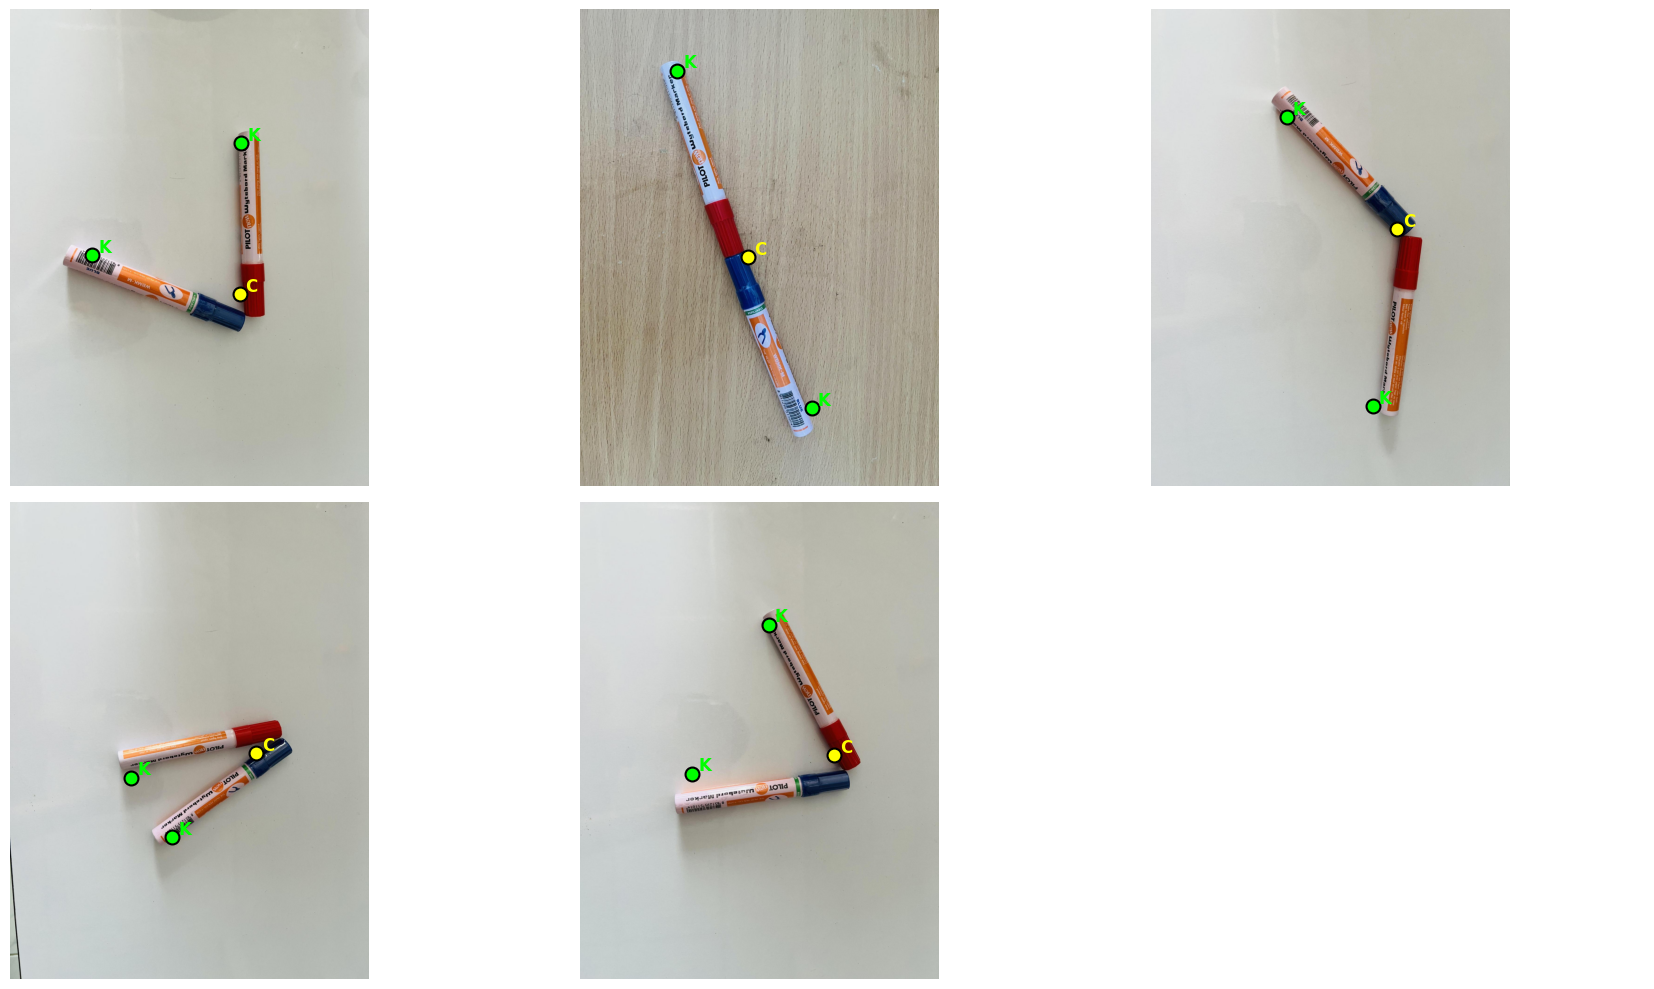

In [215]:
# Test folder and images
test_folder = "datasets/markerpenspose/test"
image_paths = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_paths.sort()

# Setup plots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, image_path in enumerate(image_paths):
    image_np, pixel_values = preprocess_image(image_path)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        raw_heatmaps = F.interpolate(outputs.heatmaps, size=(256, 192), mode='bilinear', align_corners=False)
        heatmaps = smooth_heatmaps(raw_heatmaps, kernel_size=5, sigma=1.5)
        #heatmaps = F.interpolate(outputs.heatmaps, size=(256, 192), mode='bilinear', align_corners=False)
        #heatmaps = outputs.heatmaps  # [1, 3, H, W]

    # Print predicted heatmap resolution
    #print(f"Image {i+1}: Predicted heatmap size:", heatmaps.shape[-2:])  # e.g., (64, 48)

    coords = heatmaps_to_coords(heatmaps)[0]  # [3, 2]

    # Rescale from heatmap to image dimensions
    H_img, W_img, _ = image_np.shape
    H_heat, W_heat = heatmaps.shape[-2], heatmaps.shape[-1]
    scale_x = W_img / W_heat
    scale_y = H_img / H_heat
    coords[:, 0] *= scale_x
    coords[:, 1] *= scale_y

    ax = axs[i]
    ax.imshow(image_np)
    ax.axis("off")

    # Plot only first 3 keypoints: K-C-K
    for k in range(3):
        x, y = coords[k]
        ax.scatter(x, y, color=kp_colors[k], s=100, edgecolors='black', linewidth=1.5)
        ax.text(x + 25, y - 15, kp_labels[k], fontsize=12, color=kp_colors[k], weight='bold')

    # === Optional: Overlay each predicted heatmap on the image ===
    '''for k in range(3):
        heatmap = heatmaps[0, k].cpu()
        heatmap_resized = TF.resize(heatmap.unsqueeze(0), image_np.shape[:2], interpolation=TF.InterpolationMode.BILINEAR).squeeze()
        heatmap_resized -= heatmap_resized.min()
        heatmap_resized /= heatmap_resized.max() + 1e-8
        plt.figure(figsize=(6, 6))
        plt.imshow(image_np)
        plt.imshow(heatmap_resized.numpy(), cmap='hot', alpha=0.4)
        plt.title(f"Heatmap Overlay - {kp_labels[k]}")
        plt.axis("off")
        plt.show()'''

# Hide extra plots if fewer than 6 images
for j in range(len(image_paths), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()